===========================вы потребили: 1908 кВч энергии за день
=====уровень дискомфорта по температуре: 39406 цельсий-минут за день
уровень дискомфорта по качеству воздуха: 1738 ppm-часов за день
===========================вы потребили: 1045 кВч энергии за день
=====уровень дискомфорта по температуре: 12487 цельсий-минут за день
уровень дискомфорта по качеству воздуха: 1348 ppm-часов за день
===========================вы потребили: 1477 кВч энергии за день
=====уровень дискомфорта по температуре: 20720 цельсий-минут за день
уровень дискомфорта по качеству воздуха: 1588 ppm-часов за день
===========================вы потребили: 1111 кВч энергии за день
=====уровень дискомфорта по температуре: 26611 цельсий-минут за день
уровень дискомфорта по качеству воздуха: 1617 ppm-часов за день
===========================вы потребили: 3044 кВч энергии за день
=====уровень дискомфорта по температуре: 65710 цельсий-минут за день
уровень дискомфорта по качеству воздуха: 1495 ppm-часов за день
=====

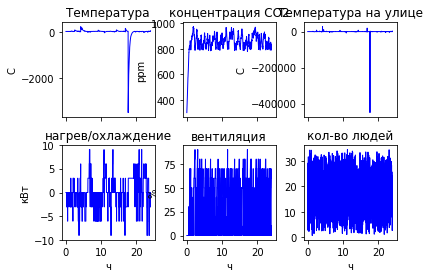

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# CONTROLLER FUNCTION
def OnOff(T,T_prev, Co2,Co2_prev,  Noc, heat_regime_prev,cool_regime_prev,vent_regime_prev):
    """
    В данной функции необходимо реализовать логику управления:
        1) радиаторами отопления
        2) кондиционером
        3) вентиляцией

    Результат работы функции - переменные:
        1) heat_regime = 0,1,2,3 - режим работы радиаторов отопления от 0 до 3
        2) cool_regime = 0,1,2,3 - режим работы кондиционера от 0 до 3
        3) vent_regime = 0[выкл]...100 [макс.мощность] - режим работы вентиляции от 0 до 100%

    Для этого у Вас имеются следующие данные:
            (данные с сенсоров)
        T        - Температура в комнате [C]
        T_prev   - Температура минуту назад [C]
        Co2      - Содержание углекислого газа [ppm]
        Co2_prev - Содержание углекислого газа минуту назад [ppm]
        Noc      - Количество людей
            (текущий режим работы климатических устройств)
        heat_regime_prev - текущий режим работы радиатора отопления
        cool_regime_prev - текущий режим работы кондиционера
        vent_regime_prev - текущий режим работы вентиляции
    """
    # инициализация
    if (T<23 and T>20):
        heat_regime = 0
        cool_regime = 0
    else:
        heat_regime = heat_regime_prev
        cool_regime = cool_regime_prev

    if Co2 <800:
        vent_regime = 0
    else:
        vent_regime = vent_regime_prev

    # логика контроллера
    if T>23:
        heat_regime = 0
        if T>T_prev:
            cool_regime = min(cool_regime_prev+1,3)

    if T < 20:
        cool_regime = 0
        if T<T_prev:
            heat_regime = min(heat_regime_prev+1,3)

    if Co2 > 700:
        if Co2>Co2_prev:
            vent_regime = min(vent_regime_prev+10,100)

    if Noc < 5:
        heat_regime = 0
        cool_regime = 0
        vent_regime = 0
        if T<18:
            heat_regime = 1

    """
    окончание описания логики
    """
#    print(cool_regime,heat_regime,vent_regime)
    return cool_regime,heat_regime,vent_regime

# MICROCLIMATE DYNAMICS FUNCTION
def microclim(dtime, Tout, T, Noc, Co2, W, Q):
    m = 540     # air mass
    Cp = 1000   # air heat capacity
    T_next = T + dtime/m/Cp*( 55*(Tout-T) +
                              200*(21-T)  +
                              120*Noc     +
                              W           +
                              Cp*Q*(21-T) +
                              0.1*m/3600*Cp*(Tout-T))
    Co2_next = Co2 + dtime/m*(  (Q+0.1*m/3600)*(300-Co2) +
                                Noc*8 )
#    print(T_next, Co2_next)
    return T_next,Co2_next

# OCCUPANCY PROFILE
def occup(time):
    xp = np.random.rand(9)*25 #np.array([0, 8.9, 9, 12, 12.1, 15, 15.1, 18, 18.1] ) + 
    xp[0] = 0
    xp[-1] = 25
    xp = np.sort(xp)
    fp = np.random.rand(9)*35 # +np.array([0, 0,   20,20, 25,   25, 7,    7,  0]) 
    return np.interp(time, xp, fp)

#out temperature profile
def outtemp(time):
    xp = np.random.rand(7)*25  #np.array([0 , 9, 12, 15, 18, 21, 25]) + 
    xp[0] = 0
    xp[-1] = 25
    xp = np.sort(xp)
    fp = np.random.randn(7)*20 #np.array([-2,-5,  0, 2,  -1, -3, -7])
    f = interpolate.interp1d(xp, fp, "cubic")
    return f(time)

# ROLLONG HORIZON SIMULATION FUNCTION
def RH():
    stamp = []
    time = 0
    T_room = 21
    T_room_prev = 21
    Noc = occup(time)
    Co2 = 300
    Co2_prev = 300
    HRP = 0
    CRP = 0
    VRP = 0
    Tout = outtemp(time)
    stamp.append([time, T_room, Noc, Co2, Tout,0,0])
    dtime = 60 #in seconds
    energy_consumed = 0.0
    comfort_penalty = 0.0
    comfort_penalty_co2 = 0.0
    
    array_for_learning =[]
    
    while time<24:
        time += dtime/3600
        Noc = occup(time)
        Tout = outtemp(time)
        cool_regime,heat_regime,vent_regime = OnOff(T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP)
        
        array_for_learning.append([T_room,T_room_prev, Co2,Co2_prev,  Noc, HRP,CRP,VRP,
                                   cool_regime,heat_regime,vent_regime])
        
        W = 3000*heat_regime-3000*cool_regime
        Q = 0.55/100*vent_regime
        T_room_prev = T_room
        Co2_prev = Co2
        HRP = heat_regime
        CRP = cool_regime
        VRP = vent_regime
        #print(HRP,CRP,VRP)
        T_room, Co2 = microclim(dtime, Tout, T_room_prev, Noc, Co2_prev, W, Q)

        stamp.append([time, T_room, Noc, Co2, Tout, W,Q])

        energy_consumed += (abs(W) + Q*1000*abs(21-Tout))*dtime/3600/1000
        if (T_room>24 and Noc>0):
            comfort_penalty += (T_room-24)*dtime/60
        if (T_room<20 and Noc>0):
            comfort_penalty += (20-T_room)*dtime/60
        if (Co2>800 and Noc>0):
            comfort_penalty_co2 += (Co2-800)*dtime/3600
    print("===========================вы потребили:",  "%0.0f" % energy_consumed, "кВч энергии за день" )
    print("=====уровень дискомфорта по температуре:", "%0.0f" % comfort_penalty, "цельсий-минут за день")
    print("уровень дискомфорта по качеству воздуха:", "%0.0f" % comfort_penalty_co2, "ppm-часов за день")
    return(stamp,array_for_learning)

# main cycle

# словарь {акшн: стейт}
d = []

#generating days with random smth inside
for i in range(20):
    stamp,array_learn = RH()
    stamp = np.asarray(stamp)
    
    #a is array [state,action]
    a = np.array(array_learn)

    for i in range(a.shape[0]):
    
#         s = tuple(a[i,-4:-1])
        d.append(a[i])
#         d[s] = d.get(s,[])
        
#         d[s] = np.concatenate((d[s],a[i,0:-4]))
    


f, axarr = plt.subplots(2, 3)
axarr[0, 0].plot(stamp[:,0], stamp[:,1], color='blue', linewidth=1)
axarr[0, 0].set_title('Температура')
axarr[0, 0].set_ylabel('C')
axarr[0, 1].plot(stamp[:,0], stamp[:,3], color='blue', linewidth=1)
axarr[0, 1].set_title('концентрация CO2')
axarr[0, 1].set_ylabel('ppm')
axarr[1, 0].plot(stamp[:,0], stamp[:,5]/1000, color='blue', linewidth=1)
axarr[1, 0].set_title('нагрев/охлаждение')
axarr[1, 0].set_ylabel('кВт')
axarr[1, 0].set_xlabel('ч')
axarr[1, 1].plot(stamp[:,0], stamp[:,6]/0.55*100, color='blue', linewidth=1)
axarr[1, 1].set_title('вентиляция')
axarr[1, 1].set_ylabel('%')
axarr[1, 1].set_xlabel('ч')
axarr[0, 2].plot(stamp[:,0], stamp[:,4], color='blue', linewidth=1)
axarr[0, 2].set_title('Температура на улице')
axarr[0, 2].set_ylabel('C')
axarr[1, 2].plot(stamp[:,0], stamp[:,2], color='blue', linewidth=1)
axarr[1, 2].set_title('кол-во людей')
axarr[1, 2].set_xlabel('ч')
plt.setp([a.get_xticklabels() for a in axarr[0, :]], visible=False)
f.subplots_adjust(wspace=0.3, hspace=0.3)

plt.show()

In [14]:
d = np.array(d)

(28820, 11)

In [2]:
# сколько всего стейтов получилось по акшну (0,0,0)
print('number of states on action(0,0,0) = ',len(d[(0,0,0)])/7)
print()

#первый стейт по акшну (0,0,0)
print('first state on action (0,0,0) = ',d[(0,0,0)][0:7])
print()

#18 стейт по акшну (10,0,0)
N_state = 18
print('18th state on action (10,0,0) = ',d[(10,0,0)][7*N_state:7*N_state + 7])

number of states on action(0,0,0) =  1966.0

first state on action (0,0,0) =  [ 21.          21.         300.         300.           3.94352462
   0.           0.        ]

18th state on action (10,0,0) =  [ 20.56762476  20.60976473 834.15397383 823.81557988  25.40265914
   0.           0.        ]


In [3]:
print(len(d.keys()))
print(d.keys())

75
dict_keys([(0.0, 0.0, 0.0), (0.0, 0.0, 1.0), (0.0, 0.0, 2.0), (10.0, 0.0, 2.0), (20.0, 0.0, 2.0), (30.0, 0.0, 2.0), (40.0, 0.0, 2.0), (50.0, 0.0, 0.0), (60.0, 0.0, 0.0), (70.0, 0.0, 0.0), (80.0, 0.0, 0.0), (10.0, 0.0, 0.0), (20.0, 0.0, 0.0), (20.0, 0.0, 1.0), (10.0, 0.0, 1.0), (30.0, 1.0, 0.0), (40.0, 1.0, 0.0), (60.0, 1.0, 0.0), (70.0, 1.0, 0.0), (80.0, 1.0, 0.0), (0.0, 2.0, 0.0), (10.0, 2.0, 0.0), (20.0, 2.0, 0.0), (30.0, 2.0, 0.0), (40.0, 2.0, 0.0), (50.0, 2.0, 0.0), (30.0, 0.0, 0.0), (40.0, 0.0, 0.0), (60.0, 2.0, 0.0), (70.0, 2.0, 0.0), (0.0, 1.0, 0.0), (10.0, 1.0, 0.0), (20.0, 1.0, 0.0), (70.0, 3.0, 0.0), (50.0, 1.0, 0.0), (30.0, 0.0, 1.0), (40.0, 0.0, 1.0), (50.0, 0.0, 1.0), (50.0, 0.0, 2.0), (60.0, 0.0, 2.0), (70.0, 0.0, 1.0), (70.0, 0.0, 2.0), (80.0, 0.0, 2.0), (50.0, 0.0, 3.0), (60.0, 3.0, 0.0), (0.0, 3.0, 0.0), (10.0, 3.0, 0.0), (20.0, 3.0, 0.0), (30.0, 3.0, 0.0), (60.0, 0.0, 1.0), (80.0, 0.0, 1.0), (90.0, 0.0, 1.0), (60.0, 0.0, 3.0), (70.0, 0.0, 3.0), (80.0, 0.0, 3.0), (9

{(0.0,
  0.0,
  0.0): array([ 21.        ,  21.        , 300.        , ...,  22.62479237,
          0.        ,   0.        ]),
 (0.0,
  0.0,
  1.0): array([ 16.0615142 ,  20.34518814, 626.38221463, ...,  13.81932121,
          1.        ,   0.        ]),
 (0.0,
  0.0,
  2.0): array([ 1.66644088e+01,  1.81334578e+01,  7.10959051e+02,  6.94473640e+02,
         2.32287717e+01,  1.00000000e+00,  0.00000000e+00, -8.08944053e+00,
        -1.00446634e+01,  8.16181519e+02,  7.98558381e+02,  1.11570611e+01,
         2.00000000e+00,  0.00000000e+00,  1.80770810e+01,  1.78748237e+01,
         8.11014426e+02,  7.98306391e+02,  1.01142094e+01,  2.00000000e+00,
         0.00000000e+00, -2.59234300e+00, -2.32577079e+00,  7.86072248e+02,
         7.82960092e+02,  1.44555339e+01,  1.00000000e+00,  0.00000000e+00,
         1.82499907e+01,  1.69942583e+01,  8.12853652e+02,  7.98270172e+02,
         2.19538408e+01,  2.00000000e+00,  0.00000000e+00,  7.65300968e+00,
         6.42668197e+00,  8.00864419e+0